# Composite Explainability

In [1]:
import numpy as np
import pandas as pd

seed = 0

df = pd.read_csv('selected_data.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

df.head()

,Flow rate_Time_skewness,Flow rate_Time_sample_entropy,Flow rate_Time_large_standard_deviation_0.1,Flow rate_Time_large_standard_deviation_0.15000000000000002,Flow rate_Frequency_signal_energy,Flow rate_Frequency_skewness,Zone7_Pressure_Time_cid_ce,Zone9_Pressure_Time_median,Zone9_Pressure_Time_percentile_95,Zone15_Pressure_Time_augmented_dickey_fuller_teststat,...,Zone23_Pressure_Time_augmented_dickey_fuller_teststat,Zone23_Pressure_Time_augmented_dickey_fuller_usedlag,Zone24_Pressure_Time_kurtosis,Zone24_Pressure_Time_sample_entropy,Zone24_Pressure_Time_augmented_dickey_fuller_usedlag,Zone24_Pressure_Frequency_skewness,Zone30_Pressure_Time_augmented_dickey_fuller_teststat,Constant_Values_Zone16_tfilling,Constant_Values_Zone24_tfilling,target
0,-0.015488,1.923687,True,True,1.929465e-07,6.022285,2.559244,63948.20,74837.140,-0.255487,...,-1.924673,1,-0.573096,2.047256,4,6.631168,-1.757511,9.05436,8.97084,1
1,1.402138,0.553437,True,True,1.754497e-07,3.987482,1.929611,55132.90,59955.070,-2.090178,...,-2.106598,4,0.582974,1.766882,4,5.913858,-2.218144,8.58738,8.81792,1
2,0.239625,0.967050,True,True,3.511431e-07,6.220548,4.163208,53513.20,96443.460,-3.147783,...,-3.154167,1,-1.383036,1.588840,1,6.875512,-2.523897,9.15164,9.09192,1
3,-0.004838,0.925972,True,True,3.876618e-07,6.390315,2.331688,16559.45,58867.045,-1.355158,...,-1.316847,1,-0.863062,1.415317,1,6.412217,-1.276491,8.25596,8.13939,1
4,0.409115,0.974327,True,True,2.228542e-07,6.012997,3.785949,13740.30,65015.820,-2.734639,...,-2.657794,1,-0.113447,1.469364,5,7.730912,-2.678957,8.77925,8.83900,1


In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed, stratify=y)

In [3]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_pred, y_true):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, columns=np.unique(y_true), index = np.unique(y_true))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (6,4))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

##### RandomForestClassifier

In [4]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=seed)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
f1_score(y_pred, y_test)

0.8111725341867908

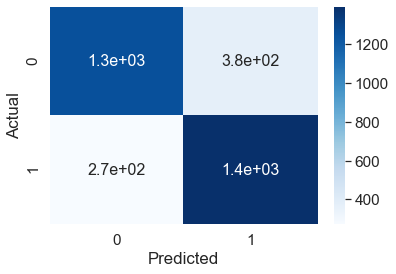

In [5]:
plot_confusion_matrix(y_pred, y_test)

##### XGBoostClassifier

In [6]:
from sklearn.metrics import f1_score
from xgboost import XGBClassifier

xgb_model = XGBClassifier(max_depth=10, n_estimators=100, random_state=seed)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
f1_score(y_pred, y_test)

0.8221709006928405

## SHAP

In [7]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(xgb_model)

shap_values = explainer.shap_values(X)

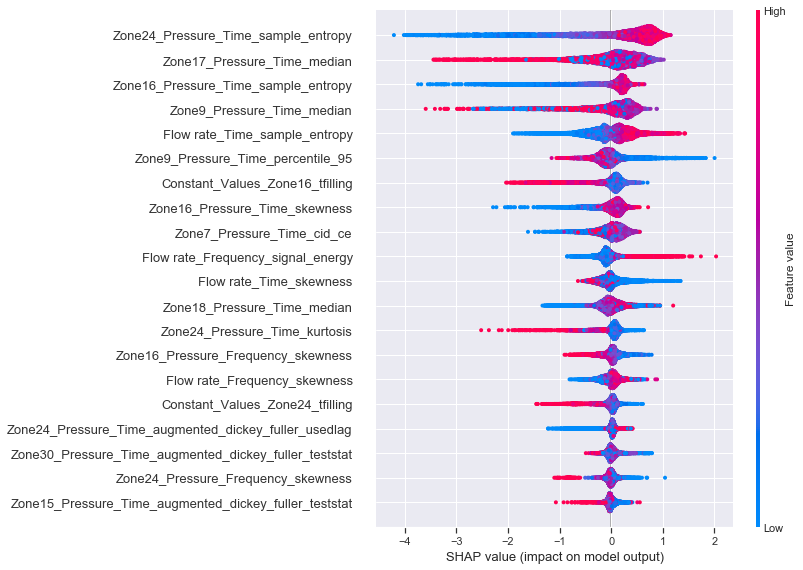

In [8]:
shap.summary_plot(shap_values, X)

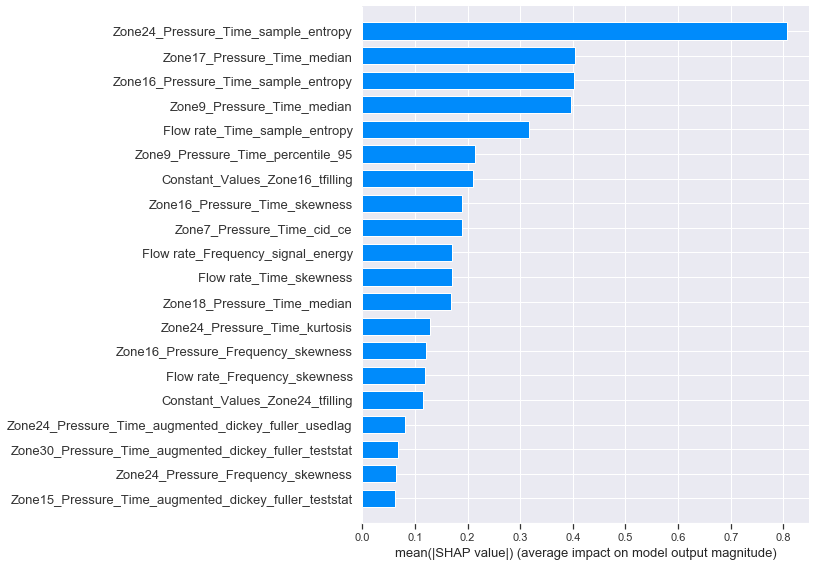

In [9]:
shap.summary_plot(shap_values, X, plot_type="bar")

## Interpret

In [10]:
from interpret.glassbox import ExplainableBoostingClassifier

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

ExplainableBoostingClassifier(binning_strategy='uniform', data_n_episodes=2000,
                              early_stopping_run_length=50,
                              early_stopping_tolerance=1e-05,
                              feature_names=['Flow rate_Time_skewness',
                                             'Flow rate_Time_sample_entropy',
                                             'Flow '
                                             'rate_Time_large_standard_deviation_0.1',
                                             'Flow '
                                             'rate_Time_large_standard_deviation_0.15000000000000002',
                                             'Flow '
                                             'rate_Frequency_signal_en...
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
      

In [11]:
from interpret import show

ebm_global = ebm.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7621/1696112323080/ -->

In [12]:
ebm_local = ebm.explain_local(X_test, y_test)
show(ebm_local)

<!-- http://127.0.0.1:7621/1696178319304/ -->